# Intersubject Correlations
*Written by Juha Lahnakoski and Luke Chang*

Synchrony between individuals happens at several levels from behavior to brain activity ([Nummenmaa et al., 2018](https://www.sciencedirect.com/science/article/pii/S2352250X1830023X), [Nastase et al., 2019](https://academic.oup.com/scan/article/14/6/667/5489905)). To an observer, synchrony during interaction or joint motion can reflect prosocial qualities such rapport ([Miles et al., 2009](https://www.sciencedirect.com/science/article/pii/S0022103109000328)) or affiliation ([Hove and Risen, 2009](https://pdfs.semanticscholar.org/393f/e817c4e137335dc7b8c304be5037c15e716c.pdf)). During physically arousing ritualistic experiences, observers may selectively synchronize their heart rates while observing related, but not unrelated individuals participating in the ritual ([Konvalinka et al., 2011](https://www.pnas.org/content/pnas/108/20/8514.full.pdf)). Synchrony of brain activity is associated with, among other things, shared psychological perspectives toward a stimulus ([Lahnakoski et al., 2014](https://www.sciencedirect.com/science/article/pii/S1053811914004996)) and friendship ([Parkinson et al., 2018](https://www.nature.com/articles/s41467-017-02722-7)), and may also be disturbed in psychiatric conditions ranging from developmental conditions such as autism ([Hasson et al., 2009](https://onlinelibrary.wiley.com/doi/pdf/10.1002/aur.89); [Salmi et al., 2013](https://www.sciencedirect.com/science/article/pii/S2213158213001411)) to more acute conditions such as first-episode psychosis ([Mäntylä et al., 2018](https://www.sciencedirect.com/science/article/pii/S0006322318314690)). Thus, measures of synchrony can offer a simple window to many psychological processes.

In brain imaging, synchrony of brain activity is most commonly measured using intersubject correlations (ISC; [Hasson et al., 2004](https://science.sciencemag.org/content/sci/303/5664/1634.full.pdf)). As the name implies, this method calculates linear correlations between participants and derives summary statistics from these correlations to measure the level of similarity of brain activity. Most commonly, ISCs are calculated locally within each voxel (or region), while recent extensions also consider intersubject connectivity between different regions of the brain (see below).

Generally, ISCs are calculated using one of two main approaches. First one calculates correlations between all participant pairs to build a full intersubject correlation matrix. This matrix can be useful in various ways as can be seen in some of the following topics. The second popular option is to use the mean activity timecourse of the other participant as a model timecourse for each person individually. This procedure produces individual, rather than pairwise, spatial maps of similarity reflecting how similarly, or “typically”, each person’s brain activates. These maps lend themselves to similar analyses as one might perform with first level results of a traditional general linear model (GLM) analysis. However, some of the individual variability is lost with the latter approach, and thus the ISC values are typically of much higher magnitude than in the pairwise matrices. Optionally, individual values of similarity to all other participants can be calculated by averaging over the rows/columns of the ISC matrices. Usually, to make the correlation coefficients more normally distributed on the whole line of real number, the Fisher’s Z transformation (inverse hyperbolic tangent) would be applied before calculating the mean in this way. The effect of Fisher’s Z transformation affects mainly the higher end of absolute correlation values, eventually stretching the correlation coefficient 1 to infinity. However, with the typical range of values of pairwise ISCs, the effects of this transformation are relatively small reaching ~10% at the higher end of the scale of r=0.5.

Overall, the brain activity measured with fMRI during naturalistic stimulation conditions can be thought to consist of for main sources 1) stimulus-driven brain activity between individuals shared by all or most of the participants, 2) individual or idiosyncratic activity elicited by the stimulus, 3) intrinsic activity that is not time-locked to the stimulus, and 4) noise from various sources. Using the above-mentioned second approach to calculate ISCs with the average activity of everyone else, we arguably only catch the brain activity that is shared by a large proportion of the participants (category 1). Thus, this method evaluates how much of an individual’s brain activity is explained by this shared component. By contrast, if smaller groups of participants, e.g. pairs of friends within the study, share similar individual activity patterns (category 2), it may be better caught by the dyadic values in the pairwise matrices. Generally, the third category of activity is not readily detected by synchrony approaches. However, with inventive experimental designs, e.g. during verbal recall of previously experienced stimuli ([Chen et al., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5191958/)), it is still possible to extract shared brain activity patterns by temporally reorganizing the data, even when the original experiences of the participants were out of sync. The optimal choice of analysis will depend on the research question and the type of shared activity patterns that are of particular interest.

Intersubject correlations give a summary statistic of synchrony over long periods of time, usually over an entire imaging session. However, the level of synchrony may change considerably from one moment to the next with the experimental condition. Time varying measures of synchrony will be discussed below, after we consider the topic of statistical inference on static intersubject correlation values.


In [39]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress, zscore, fdr, threshold
from nltools.file_reader import onsets_to_dm
from nltools.external import glover_hrf
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from sklearn.metrics import pairwise_distances
from scipy.stats import binom, ttest_1samp, pearsonr


base_dir = '/Volumes/Engram/Data/Sherlock/fmriprep'


# Extract Average ROI activity


We have already done this step for you, but want to show you how to extract average activity within a set of ROIs from a functional parcellation. There are many ways to do this, but here we will write out a separate CSV for each participant's run.

In [16]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)

In [ ]:
for scan in ['Part1', 'Part2']:
    file_list = glob.glob(os.path.join(base_dir, '*', 'func', f'*crop*{scan}*hdf5'))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        print(sub)
        data = Brain_Data(f)
        roi = data.extract_roi(mask)
        pd.DataFrame(roi.T).to_csv(os.path.join(os.path.dirname(f), f"{sub}_{scan}_Average_ROI_n50.csv" ), index=False)

## Load Time Series

In [13]:
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(base_dir, '*', 'func', '*Part1*csv'))]
sub_list.sort()

sub_timeseries = {}
for sub in sub_list:
    part1 = pd.read_csv(os.path.join(base_dir, sub, 'func', f'{sub}_Part1_Average_ROI_n50.csv'))
    part2 = pd.read_csv(os.path.join(base_dir, sub, 'func', f'{sub}_Part2_Average_ROI_n50.csv'))
    sub_data = part1.append(part2)
    sub_data.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = sub_data

# Compute Similarity of Time Courses

## Average Pairwise Similarity Matrix

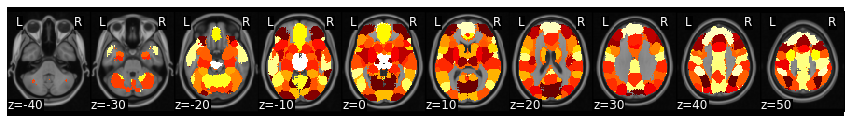

In [18]:
isc = {}
for roi in range(50):
    sub_rois = {}
    for sub in sub_timeseries:
        sub_rois[sub] = sub_timeseries[sub].loc[roi]
    sub_rois = pd.DataFrame(sub_rois)
    time_dist = Adjacency(1 - pairwise_distances(sub_rois.T, metric='correlation'), matrix_type='similarity')
    isc[roi] = time_dist.mean()
isc_brain = roi_to_brain(pd.Series(isc), mask_x)

isc_brain.plot()

## Similarity with Average Response

In [23]:
all_rois = {}
for roi in range(50):
    sub_rois = {}
    for sub in sub_timeseries:
        sub_rois[sub] = sub_timeseries[sub].loc[roi]
    all_rois[roi] = pd.DataFrame(sub_rois)
#     time_dist = Adjacency(1 - pairwise_distances(sub_rois.T, metric='correlation'), matrix_type='similarity')
#     isc[roi] = time_dist.mean()
# isc_brain = roi_to_brain(pd.Series(isc), mask_x)


In [28]:
[all_rois[0][x] for x in all_rois[0]]

[0     1.755921
 1     5.826709
 2     1.881618
 3     3.776599
 4     8.665937
 5     4.075354
 6     2.421694
 7     2.864211
 8     2.704671
 9     1.684665
 10    4.462688
 11    4.611202
 12   -0.565856
 13    3.747239
 14    0.801690
 15    1.274180
 16    2.816266
 17    2.639034
 18    0.981228
 19    5.246728
 20    4.516569
 21    0.973018
 22    1.266119
 23    3.339710
 24    5.465310
 25    2.181135
 26    1.948675
 27    4.325061
 28    2.513372
 29    2.057098
 30    0.002903
 31    2.749903
 32    3.362605
 33    2.350355
 34   -1.901185
 35    8.479704
 36    0.953000
 37    2.271374
 38    3.177643
 39    4.367660
 40    1.390778
 41    3.038824
 42    1.004956
 43    3.307391
 44    0.914738
 45    3.266528
 46    4.668272
 47    4.707671
 48   -0.345977
 49    0.681969
 Name: sub-01, dtype: float64,
 0    -0.110693
 1     1.628219
 2    -0.446085
 3     0.524105
 4     3.806597
 5     0.811877
 6     0.501276
 7     0.904836
 8    -0.418394
 9    -0.364482
 10    0.

In [49]:
i=0
avg_isc_r = {}
for roi in range(50):
    all_r = {}
    for sub in all_rois[roi]:
        group_avg = all_rois[roi].loc[:,all_rois[roi].columns != sub].mean(axis=1)
        all_r[sub], p = pearsonr(all_rois[roi][sub], group_avg)
        avg_isc_r[roi] = pd.Series(all_r)
avg_isc_r = pd.DataFrame(avg_isc_r)
avg_isc_r

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
sub-01,0.748356,0.736447,0.865057,0.684058,0.694833,0.743998,0.738786,0.823943,0.624566,0.808790,...,0.652550,0.118277,0.363761,0.569747,0.365645,0.264736,0.686591,0.662956,0.712507,0.799203
sub-02,0.569214,0.861525,0.818693,0.737793,0.740949,0.642857,0.769693,0.832345,0.732641,-0.281420,...,0.623868,0.267525,-0.503297,-0.286891,0.417314,0.764211,0.529019,0.774178,0.893284,0.874796
sub-03,0.215853,0.624439,0.637802,0.713321,0.798070,0.790270,0.788946,0.879664,0.869180,0.819086,...,0.140377,0.347873,0.131346,0.452738,0.478019,0.499744,0.723832,0.717610,0.794710,0.774728
sub-04,0.306526,0.609787,0.790974,0.396001,0.603083,0.252118,0.525458,0.628255,0.679065,0.637533,...,0.745460,0.677036,0.418312,0.301435,0.272332,0.605047,0.820816,0.677751,0.685901,0.415052
sub-05,0.428479,0.694906,0.746619,0.838413,0.792086,0.801231,0.765997,0.820664,0.867333,0.814567,...,0.179571,0.180285,-0.001464,0.599250,0.606638,0.818953,0.905427,0.615107,0.591806,0.639295
sub-06,0.294382,0.621599,0.832831,0.857960,0.813303,0.841535,0.854475,0.822105,0.890826,0.761885,...,0.658344,0.397154,0.119892,-0.330484,0.046226,0.501395,0.506246,0.529517,0.792454,0.651299
sub-07,0.733165,0.873626,0.682673,0.466276,0.328735,0.618183,0.643854,0.782665,0.789117,0.686631,...,0.535771,0.685958,0.457837,0.613749,0.605141,0.750901,0.782315,0.698883,0.803718,0.752458
sub-08,0.387250,0.364086,0.485767,0.566322,0.154568,-0.324794,0.323130,0.693798,0.154706,0.077630,...,0.204386,0.476639,0.522318,0.554205,0.318634,0.417845,0.521245,0.820830,0.105545,0.687005
sub-09,0.734020,0.792309,0.877801,0.859824,0.796496,0.782738,0.771366,0.834529,0.762212,0.671906,...,0.460337,0.367605,0.451114,0.302941,-0.225773,0.115316,0.289164,0.539802,0.792066,0.621553
sub-10,0.528940,0.333966,0.683110,0.661799,0.434066,0.565455,0.471665,0.551834,0.481256,0.463447,...,0.397182,0.482234,-0.206256,-0.087457,0.493583,0.673510,0.817466,0.905424,0.879214,0.727890


In [58]:
n_boot = 5000

all_bootstraps = []
for b in range(n_boot):
    all_bootstraps.append(np.mean(np.random.choice([1,-1], avg_isc_r.shape) * avg_isc_r, axis=0))
all_bootstraps = pd.DataFrame(all_bootstraps)


In [60]:
np.mean(all_bootstraps > avg_isc_r.mean())

0     0.0000
1     0.0000
2     0.0000
3     0.0000
4     0.0000
5     0.0000
6     0.0000
7     0.0000
8     0.0000
9     0.0000
10    0.0000
11    0.0000
12    0.0000
13    0.0000
14    0.0000
15    0.0000
16    0.0000
17    0.0000
18    0.0000
19    0.0000
20    0.0000
21    0.0000
22    0.0000
23    0.0000
24    0.0000
25    0.0002
26    0.0000
27    0.0000
28    0.0002
29    0.0000
30    0.0000
31    0.0000
32    0.0000
33    0.0000
34    0.0000
35    0.0000
36    0.0000
37    0.0000
38    0.0000
39    0.0002
40    0.0000
41    0.0000
42    0.0042
43    0.0040
44    0.0006
45    0.0000
46    0.0000
47    0.0000
48    0.0000
49    0.0000
dtype: float64

# Intersubject Correlations
*Written by Juha Lahnakoski and Luke Chang*

Synchrony between individuals happens at several levels from behavior to brain activity ([Nummenmaa et al., 2018](https://www.sciencedirect.com/science/article/pii/S2352250X1830023X), [Nastase et al., 2019](https://academic.oup.com/scan/article/14/6/667/5489905)). To an observer, synchrony during interaction or joint motion can reflect prosocial qualities such rapport ([Miles et al., 2009](https://www.sciencedirect.com/science/article/pii/S0022103109000328)) or affiliation ([Hove and Risen, 2009](https://pdfs.semanticscholar.org/393f/e817c4e137335dc7b8c304be5037c15e716c.pdf)). During physically arousing ritualistic experiences, observers may selectively synchronize their heart rates while observing related, but not unrelated individuals participating in the ritual ([Konvalinka et al., 2011](https://www.pnas.org/content/pnas/108/20/8514.full.pdf)). Synchrony of brain activity is associated with, among other things, shared psychological perspectives toward a stimulus ([Lahnakoski et al., 2014](https://www.sciencedirect.com/science/article/pii/S1053811914004996)) and friendship ([Parkinson et al., 2018](https://www.nature.com/articles/s41467-017-02722-7)), and may also be disturbed in psychiatric conditions ranging from developmental conditions such as autism ([Hasson et al., 2009](https://onlinelibrary.wiley.com/doi/pdf/10.1002/aur.89); [Salmi et al., 2013](https://www.sciencedirect.com/science/article/pii/S2213158213001411)) to more acute conditions such as first-episode psychosis ([Mäntylä et al., 2018](https://www.sciencedirect.com/science/article/pii/S0006322318314690)). Thus, measures of synchrony can offer a simple window to many psychological processes.

In brain imaging, synchrony of brain activity is most commonly measured using intersubject correlations (ISC; [Hasson et al., 2004](https://science.sciencemag.org/content/sci/303/5664/1634.full.pdf)). As the name implies, this method calculates linear correlations between participants and derives summary statistics from these correlations to measure the level of similarity of brain activity. Most commonly, ISCs are calculated locally within each voxel (or region), while recent extensions also consider intersubject connectivity between different regions of the brain (see below).

Generally, ISCs are calculated using one of two main approaches. First one calculates correlations between all participant pairs to build a full intersubject correlation matrix. This matrix can be useful in various ways as can be seen in some of the following topics. The second popular option is to use the mean activity timecourse of the other participant as a model timecourse for each person individually. This procedure produces individual, rather than pairwise, spatial maps of similarity reflecting how similarly, or “typically”, each person’s brain activates. These maps lend themselves to similar analyses as one might perform with first level results of a traditional general linear model (GLM) analysis. However, some of the individual variability is lost with the latter approach, and thus the ISC values are typically of much higher magnitude than in the pairwise matrices. Optionally, individual values of similarity to all other participants can be calculated by averaging over the rows/columns of the ISC matrices. Usually, to make the correlation coefficients more normally distributed on the whole line of real number, the Fisher’s Z transformation (inverse hyperbolic tangent) would be applied before calculating the mean in this way. The effect of Fisher’s Z transformation affects mainly the higher end of absolute correlation values, eventually stretching the correlation coefficient 1 to infinity. However, with the typical range of values of pairwise ISCs, the effects of this transformation are relatively small reaching ~10% at the higher end of the scale of r=0.5.

Overall, the brain activity measured with fMRI during naturalistic stimulation conditions can be thought to consist of for main sources 1) stimulus-driven brain activity between individuals shared by all or most of the participants, 2) individual or idiosyncratic activity elicited by the stimulus, 3) intrinsic activity that is not time-locked to the stimulus, and 4) noise from various sources. Using the above-mentioned second approach to calculate ISCs with the average activity of everyone else, we arguably only catch the brain activity that is shared by a large proportion of the participants (category 1). Thus, this method evaluates how much of an individual’s brain activity is explained by this shared component. By contrast, if smaller groups of participants, e.g. pairs of friends within the study, share similar individual activity patterns (category 2), it may be better caught by the dyadic values in the pairwise matrices. Generally, the third category of activity is not readily detected by synchrony approaches. However, with inventive experimental designs, e.g. during verbal recall of previously experienced stimuli ([Chen et al., 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5191958/)), it is still possible to extract shared brain activity patterns by temporally reorganizing the data, even when the original experiences of the participants were out of sync. The optimal choice of analysis will depend on the research question and the type of shared activity patterns that are of particular interest.

Intersubject correlations give a summary statistic of synchrony over long periods of time, usually over an entire imaging session. However, the level of synchrony may change considerably from one moment to the next with the experimental condition. Time varying measures of synchrony will be discussed below, after we consider the topic of statistical inference on static intersubject correlation values.


# Intersubject functional connectivity
Functional connectivity reflects the similarity of activity timecourses between pairs of regions and it has been particularly popular in recent years in inquiry to the functional architecture of the brain during resting state, in the absence of task or external stimulation. Given enough data, these resting state correlations are stable within an individual and perturbations to the correlations between regions caused by external stimuli or tasks are relatively small ([Gratton et al., 2018](https://www.sciencedirect.com/science/article/pii/S0896627318302411)). Thus, functional connectivity appears to reflect intrinsic fluctuations of BOLD activity more than stimulus evoked processing.

To specifically address how brain regions coactivate due to naturalistic stimulation, intersubject synchrony analysis was recently extended to measure brain connectivity between subjects ([Simony et al., 2016](https://www.nature.com/articles/ncomms12141)), or intersubject functional connectivity (ISFC). This method has the benefit that it only highlights those connections that are activated consistently between participants by the stimulus while disregarding the intrinsic fluctuations as they are not time-locked between individuals. This type of intersubject connectivity can suggest how distant brain regions cooperate to make sense of the incoming stimulus streams. However, it can also highlight pairs of regions that show similar temporal activity patterns that are driven by the external stimulus rather than neural connections between the regions.  which should be taken into account in the interpretation. Future work will evaluate the usefulness of these measures for elucidating individual variability and, for example, effects of psychiatric disorders on intersubject connectivity. However, our initial results presented in this conference suggest that stimulus-driven connectivity may reveal exciting insight into how functional network structure relevant for understanding naturalistic events is affected by social interaction disorders (see poster 206 and the accompanying talk in the Neurodevelopmental Disorders and Environmental Impact oral session).


# Temporal dynamics of intersubject synchrony
Most studies so far have focused on correlations calculated over entire datasets to reveal the average connectivity or intersubject similarity in a group of participants. However, functional brain networks are widely accepted to be dynamic. Thus, it is not clear whether tools like correlation, which assumes a constant statistical dependence between the variables over the entire imaging session, are the most appropriate way to analyze data gathered during complex naturalistic stimulation.

To get an intuition of temporal constituents of Pearson’s correlation coefficient of two signals, it can be written as the expected value of the elementwise product of the signals (standardized to zero mean and unit variance). This case can be seen in the top panel of video 2, where two independent sinusoidal signals are shown in blue and red, and their elementwise product is shown in gray dotted line. The correlation coefficient of the two signals is the expected value of the gray signal, that is, sum of the timepoints divided by N-1, where N is the number of timepoints. This timecourse gives direct insight to which timepoints are contributing most to the correlation. However, as can be seen from this simple example, the correlation coefficient tends to be dominated by high-amplitude timepoints; when one (or both) of the signals is close to zero the mean value, the product is also close to zero. By contrast, when both are far away from zero, the timepoints contribute more to the overall correlation, either negatively when the signals have opposite signs or positively when the signs are the same. The vertical histogram on the left shows a dynamically updating distribution of the elementwise products and the correlation coefficient as the number of timepoints increases. As can be seen, after a few periods of the signal, the correlation coefficient stabilizes near zero. Similarly, ISC can be derived by producing a similar timecourse of elementwise products for all pairs of subjects and averaging over the participant pairs ([Lahnakoski et al., 2017](https://onlinelibrary.wiley.com/doi/pdf/10.1002/hbm.23591)). This timecourse directly produces the ISC values, but the dependence on the extreme amplitude values remains and the timecourse only shows the relative importance of the individual timepoints rather than a readily interpretable statistical measure of synchrony.

A simple, and still a popular way of looking at temporal variability of synchrony and limit the effect of the local amplitudes is to calculate correlation in sliding time windows. This allows the estimation of synchrony also during time windows when the signals are close to their mean values as the amplitude within each time window is standardized when the correlation is calculated. However, the length of the temporal window forces a trade-off between temporal accuracy and stability of the correlation coefficient calculated in that window. Very short time windows allow one to follow precisely when correlations occur, but short windows yield extremely unstable correlations, which can be dominated completely by e.g. single co-occurring spikes or slopes. Thus, sliding-window correlations in short time-windows are often characterized by extreme correlation values that change signs wildly.

Calculating the phase synchronization or phase locking of signals is one option to estimate timevarying synchronization of signals in a way that largely separates synchronization from signal amplitudes. It has been used widely for electrophysiological measures such as EEG and MEG, and more recently also for fMRI ([Glerean et al., 2012](https://www.liebertpub.com/doi/pdfplus/10.1089/brain.2011.0068)). Phase synchronization leverages the Hilbert transform to transform the real-valued signals into a complex valued, analytic signal, which is a generalization of the phasor notation of sinusoidal signals that are used widely in engineering applications. For illustration, two examples of analytic signals with constant frequency and amplitude are shown in the bottom panel of video 2, plotted in three dimensions (real, imaginary and time axes). In contrast to a time-invariant phasor, an analytic signal has a timevarying amplitude envelope and frequency and can thus be used to track changes in synchrony over time. However, for meaningful separation of the envelope and phase of the signal, the original signal has to be contained in a limited frequency band, which can be obtained through band-pass filtering. The smaller this frequency band is, the better the amplitude envelope is separated into a lower frequency than the phase of the signal in the pass-band ([Glerean et al., 2012](https://www.liebertpub.com/doi/pdfplus/10.1089/brain.2011.0068)). However, poorly designed filters may affect the shape of the signal considerably and in extreme cases even remove the signal of interest. For example, some filters can cause non-linear phase shifts across the frequency spectrum, or excessively tight pass-band may miss important frequencies completely.

Compared to sliding-window correlations, phase synchronization has the benefit that no explicit time windowing is required and synchronization is estimated at the original sampling frequency of the signals. However, in a single pairwise comparison, phase synchrony can get extreme values by chance, much like a stopped clock that shows the right time twice a day. This is illustrated in the bottom panel of Video 2. Despite the two signals being independent, the histogram on the left shows that many of the time points show extreme synchrony values. Accordingly, the estimate of mean synchrony oscillates with the phase of the signals, until eventually stabilizing around zero as expected for independent signals. Thus, phase synchrony of two signals has the potential of producing extreme synchrony values much like time windowed correlations. This can be mitigated by averaging. Averaging over the timepoints of a full session, intersubject phase synchronization (ISPS) of regional activity produces highly similar group-level results to ISC. However, this removes the benefit of the temporal accuracy of ISPS and is thus of limited use. By contrast, averaging over (pairs of) subjects improves the reliability of synchrony in a larger population while retaining the temporal accuracy.

Note that, here, we have used the cosine of the angular difference as a measure of pairwise synchrony. This produces time-averaged values that are consistent with the ISCs in the regions. However, there are other measures can also be derived, such as the phase locking value, that is the absolute value of the mean of the phase vectors of the participants ([Glerean et al., 2012](https://www.liebertpub.com/doi/pdfplus/10.1089/brain.2011.0068)). This is simpler than pairwise measures, and can be beneficial particularly where memory is of concern, but it is limited in the range [0 1] rather than [-1 1] as for correlation coefficients. 

![null_distribution](../../images/isc/PhaseSynchronyAndCorrelation.gif)


# Statistics for intersubject synchrony
Because of the dependence between the pairwise correlation values and the inflated number of variables in the pairwise correlation matrices, non-parametric statistics are generally preferred when evaluating the significance of these correlations. This is often achieved by creating surrogate data and repeating the same analysis enough times (e.g. tens of thousands of iterations) to build an empirical null distribution. Surrogate data can be created, for example, by circularly shifting the timecourses of the participants or scrambling the phases of the Fourier transform of the signals and transforming these scrambled signals back to the time domain. Various blockwise scrambling techniques have also been applied and autoregressive models have been proposed to create artificial data for statistical inference . These approaches have the benefit that, when properly designed, they retain important characteristics of the original signal, such as the frequency content and autocorrelation, while removing temporal synchrony in the data. To illustrate these approaches, Video/Figure 1 below shows the process of creating these null distributions and compares these to a similar distribution built based on real resting state data of the same duration in the same participants recorded just prior to the movie data in the same imaging study. Resting state is an ideal condition for demonstrating the true null distribution of intersubject correlation as it involves no external synchronizing factors apart from the repeating noise of the scanner gradients, which are generally not of interest to us. Thus, any correlations in the resting state data arise by chance. As can be seen, the null distributions based on the surrogate data follow the distribution of resting state ISCs well as the number of iterations increases.

 
Figure 1: Distributions of pairwise ISC values  in real movie data (blue), compared with null distributions based on temporally shifted (red) and phase scrambled (yellow) data, as well as real resting state data (purple). Top rows show the timecourse of a randomly selected voxel of one participant that have been shifted or scrambled in the case of the surrogate timecourses. Second row shows the timecourse of a second participant extracted from the same voxel. Bottom plot shows how the distributions evolve as the number of iterations increases. Dashed vertical lines correspond to the 95th percentile of each distribution. Note the distinctly extended right tail in the movie data, whereas other distributions appear highly consistent.

The number of participants, N, of the mean of pairwise ISC analysis greatly affects the null distribution. As the values are always below one, the standard deviation of the null distribution is reduced with the square of N (see Figure 2 below). This is true also for the resting state data and thus it does not affect the validity of the distributions. However, as a result, very small correlations become significant as N increases, which may not be desirable as interpretation of very weak correlations can be troublesome.

When the mean activity of participants is used the activity timecourse of a left-out participant, the effects of the sample size and variance of the ISC values is greatly reduced and group level statistics can be derived more similarly to traditional second level GLM analyses. For example, parametric t-statistics are largely consistent with those derived based on surrogate or resting state data.

Overall, the statistics for ISFC can be performed similarly to local ISC. However, it is important to note that the distribution of mean correlations between two different regions differs from within-region correlations. In particular, as the number of participant pairs increases, the distribution of ISC values is increasingly skewed to the right as negative correlations are eliminated nearly completely due to dependencies between the pairwise correlations. This is intuitive as any larger group of individuals who correlate negatively with other participants would often be positively correlated within the group, thus cancelling out any large negative values in the mean ISC. By contrast, when correlations are calculated between two different regions, negative values can occur if the stimulus-evoked activity timecourses in the two regions are consistently anticorrelated.

The distributions of ISCs and ISFCs in real and null data are depicted below as a function of the number of participants on a logarithmic color scale. Overall, the null distribution of the ISFC values appears slightly wider than the ISC null distribution. However, this is mainly driven by the increased number values in the correlation matrices for the ISFC (off-diagonal entries) than ISC (diagonal entries) as the shape of the distribution appears similar but the tail is truncated (see bottom right panel).
 
![null_distribution](../../images/isc/NullMethodsVsMovieAndRest.gif)

Figure 2: Distributions of real ISCs and ISFCs (top) and their null distributions (bottom) with different numbers of participants. Left-most panels show the ISCs and middle panels the ISFCs. Right-most panels show example distributions from the two left panels corresponding to the case with N=11 participants. The distributions are plotted on a logarithmic scale to make the differences in the left tails visible. Note that negative numbers exist in the real ISFC distribution while they are largely eliminated in the ISC.

Statistics for timevarying measures of synchrony can largely follow a similar bootstrapping approach as with the static measures of synchrony. However, depending on the values that are used, statistics of phase synchrony differ slightly from linear measures of synchrony. In particular, circular statistics can be used to estimate the parametric statistics of phase differences on the unit circle, as wrapping of the phase angle causes the angular difference to change signs as the signals rotate around the circle. Thus, angular difference of –pi and pi are equivalent on the unit circle, but are at the different ends of a linear axis. However, in the current examples, we have used cosines of the angular differences, which is an even function and thus is indifferent to the sign of the angular difference. It also naturally maps the angular difference to a linear range between -1 and 1 similar to the correlation coefficient, thus simplifying the interpretation. If the sign of the phase shift is of interest, such as when trying to infer the temporal precedence of one signal over another, alternative measures taking into account the direction of the phase shift may be preferable.


# Recommended reading
We might want to highlight a few key papers and just leave embedded links for the other ones.

* Chen, J., Leong, Y. C., Honey, C. J., Yong, C. H., Norman, K. A., and Hasson, U. (2017). Shared memories reveal shared structure in neural activity across individuals. Nat. Neurosci. 20, 115–125. doi:10.1038/nn.4450.

* Glerean, E., Salmi, J., Lahnakoski, J. M., Jääskeläinen, I. P., and Sams, M. (2012). Functional Magnetic Resonance Imaging Phase Synchronization as a Measure of Dynamic Functional Connectivity. Brain Connect. 2, 91–101. doi:10.1089/brain.2011.0068.

* Gratton, C., Laumann, T. O., Nielsen, A. N., Greene, D. J., Gordon, E. M., Gilmore, A. W., et al. (2018). Functional Brain Networks Are Dominated by Stable Group and Individual Factors, Not Cognitive or Daily Variation. Neuron 98, 439-452.e5. doi:10.1016/j.neuron.2018.03.035.

* Hasson, U., Avidan, G., Gelbard, H., Vallines, I., Harel, M., Minshew, N., et al. (2009). Shared and idiosyncratic cortical activation patterns in autism revealed under continuous real-life viewing conditions. Autism Res. 2, 220–231. doi:10.1002/aur.89.

* Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., and Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. Science (80-. ). 303, 1634–40. doi:10.1126/science.1089506.

* Hove, M. J., and Risen, J. L. (2009). It’s All in the Timing: Interpersonal Synchrony Increases Affiliation. Soc. Cogn. 27, 949–960. doi:10.1521/soco.2009.27.6.949.

* Konvalinka, I., Xygalatas, D., Bulbulia, J., Schjødt, U., Jegindø, E. M., Wallot, S., et al. (2011). Synchronized arousal between performers and related spectators in a fire-walking ritual. Proc. Natl. Acad. Sci. U. S. A. 108, 8514–8519. doi:10.1073/pnas.1016955108.

* Lahnakoski, J. M., Glerean, E., Jääskeläinen, I. P., Hyönä, J., Hari, R., Sams, M., et al. (2014). Synchronous brain activity across individuals underlies shared psychological perspectives. Neuroimage 100C, 316–324. doi:10.1016/j.neuroimage.2014.06.022.

* Lahnakoski, J. M., Jääskeläinen, I. P., Sams, M., and Nummenmaa, L. (2017). Neural mechanisms for integrating consecutive and interleaved natural events. Hum. Brain Mapp. doi:10.1002/hbm.23591.

* Mäntylä, T., Nummenmaa, L., Rikandi, E., Lindgren, M., Kieseppä, T., Hari, R., et al. (2018). Aberrant Cortical Integration in First-Episode Psychosis During Natural Audiovisual Processing. Biol. Psychiatry 84, 655–664. doi:10.1016/j.biopsych.2018.04.014.

* Miles, L. K., Nind, L. K., and Macrae, C. N. (2009). The rhythm of rapport: Interpersonal synchrony and social perception. J. Exp. Soc. Psychol. 45, 585–589. doi:10.1016/j.jesp.2009.02.002.

* Nummenmaa, L., Lahnakoski, J. M., and Glerean, E. (2018). Sharing the social world via intersubject neural synchronisation. Curr. Opin. Psychol. 24. doi:10.1016/j.copsyc.2018.02.021.

* Parkinson, C., Kleinbaum, A. M., and Wheatley, T. (2018). Similar neural responses predict friendship. Nat. Commun. 9, 1–14. doi:10.1038/s41467-017-02722-7.

* Salmi, J., Roine, U., Glerean, E., Lahnakoski, J., Nieminen-Von Wendt, T., Tani, P., et al. (2013). The brains of high functioning autistic individuals do not synchronize with those of others. NeuroImage Clin. 3. doi:10.1016/j.nicl.2013.10.011.

* Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., et al. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. Nat. Commun. 7. doi:10.1038/ncomms12141.



# Contributions

Juha Lahnakoski wrote text, Luke Chang edited text and developed the practical tutorials.
